Wrap Nick's code in a notebook so we can visualize results.

In [11]:
import string
from enum import Enum

import numpy as np
from pydantic import BaseModel
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from skimage.transform import rotate


class PlateSize(Enum):
    """"Plate Size processed by the pipeline."""
    SIZE_6 = 6
    SIZE_12 = 12
    SIZE_24 = 24
    SIZE_48 = 48
    SIZE_96 = 96
    SIZE_384 = 384
    SIZE_1536 = 1536


"""Plate Dimensions or each plate size."""
PLATE_DIMS = {
    PlateSize.SIZE_6: (2, 3),
    PlateSize.SIZE_12: (3, 4),
    PlateSize.SIZE_24: (4, 6),
    PlateSize.SIZE_48: (6, 8),
    PlateSize.SIZE_96: (9, 12),
    PlateSize.SIZE_384: (16, 24),
    PlateSize.SIZE_1536: (32, 48),
}

""" y component of the 2D rotation matrix for each degree in [0,180)."""
ROTATION = np.vstack(
    [
        -np.sin(np.arange(0, np.pi, np.pi / 180)),
        np.cos(np.arange(0, np.pi, np.pi / 180)),
    ]
)


class PlateParams(BaseModel):
    rotate: int
    """Counterclockwise rotation of image in degrees."""

    bbox: tuple[int, int, int, int]
    """Bounding box of plate after rotation, [ymin,ymax,xmin,xmax]."""

    size: PlateSize
    """The plate size, also determines layout."""

    radii: int
    """Well radius."""

    X: list[int]
    """The the x axis points for wells."""

    Y: list[int]
    """The the y axis points for wells."""


def get_wells(image: np.ndarray) -> tuple[list[float], list[float], list[float], int]:
    """Get well locations and radii.

    Since RT-CETSA are generally high signal to noise, no need for anything fancy
    to detect wells. Simple Otsu threshold to segment the well, image labeling,
    and estimation of radius based off of area (assuming the area is a circle).

    The input image is a binary image.
    """

    markers, n_objects = ndi.label(image)

    radii = []
    cx = []
    cy = []
    for s in ndi.find_objects(markers):
        cy.append((s[0].start + s[0].stop) / 2)
        cx.append((s[1].start + s[1].stop) / 2)
        radii.append(np.sqrt((markers[s] > 0).sum() / np.pi))

    return cx, cy, radii, n_objects


def get_plate_params(image: np.ndarray) -> PlateParams:

    # Calculate a simple threshold
    threshold = threshold_otsu(image)

    # Get initial well positions
    cx, cy, radii, n_objects = get_wells(image > threshold)

    # Calculate the counterclockwise rotations
    locations = np.vstack([cx, cy]).T
    transform = locations @ ROTATION

    # Find the rotation that aligns the long edge of the plate horizontally
    angle = np.argmin(transform.max(axis=0) - transform.min(axis=0))

    # Shortest rotation to alignment
    if angle > 90:
        angle -= 180

    # Rotate the plate and recalculate well positions
    print(f"mean before rotate: {np.mean(image)}")
    
    image_rotated = rotate(image, angle, preserve_range=True)
    print(f"mean after rotate: {np.mean(image_rotated)}")

    # Recalculate well positions
    cx, cy, radii, n_objects = get_wells(image_rotated > threshold)

    # Determine the plate layout
    n_wells = len(cx)
    plate_config = None
    for layout in PlateSize:
        error = abs(1 - n_wells / layout.value)
        if error < 0.05:
            plate_config = layout
            break
    if plate_config is None:
        raise ValueError("Could not determine plate layout")

    # Get the mean radius
    radii_mean = int(np.mean(radii))

    # Get the bounding box after rotation
    cx_min, cx_max = np.min(cx) - 2 * radii_mean, np.max(cx) + 2 * radii_mean
    cy_min, cy_max = np.min(cy) - 2 * radii_mean, np.max(cy) + 2 * radii_mean
    bbox = (int(cy_min), int(cy_max), int(cx_min), int(cx_max))

    # Get X and Y indices
    points = []
    for p, mval in zip([cy, cx], [int(cy_min), int(cx_min)]):
        z_pos = list(p)
        z_pos.sort()
        z_index = 0
        z_count = 1
        Z = [z_pos[0]]
        for z in z_pos[1:]:
            if abs(Z[z_index] - z) < radii_mean // 3:
                Z[z_index] = (Z[z_index] * z_count + z) / (z_count + 1)
                z_count += 1
            else:
                Z[z_index] = int(Z[z_index])
                Z.append(z)
                z_index += 1
                z_count = 1
        Z[-1] = int(Z[-1])
        points.append(Z)

    Y = points[0]
    X = points[1]

    # TODO: In case of merged wells, try to remove the bad point

    return PlateParams(
        rotate=angle,
        size=plate_config,
        radii=int(radii_mean),
        bbox=bbox,
        X=X,
        Y=Y,
    )


def extract_intensity(image: np.ndarray, x: int, y: int, r: int) -> int:
    """Get the well intensity

    Args:
        image: _description_
        x: x-position of the well centerpoint
        y: y-position of the well centerpoint
        r: radius of the well

    Returns:
        int: The background corrected mean well intensity
    """
    assert r >= 5

    # get a large patch to find background pixels
    x_min = max(x - r, 0)
    x_max = min(x + r, image.shape[1])
    y_min = max(y - r, 0)
    y_max = min(y + r, image.shape[0])
    patch = image[y_min:y_max, x_min:x_max]
    background = patch.ravel()
    background.sort()

    # Subtract lowest pixel values from average center pixel values
    return int(np.mean(patch) - np.mean(background[: int(0.05 * background.size)]))


def index_to_battleship(x: int, y: int, size: PlateSize) -> str:
    """Get the battleship notation of a well index.

    Args:
        x: x-position of the well centerpoint
        y: y-position of the well centerpoint

    Returns:
        str: The string representation of the well index (i.e. A1)
    """
    # The y-position should be converted to an uppercase well letter
    row = ""
    if y >= 26:
        row = "A"
    row = row + string.ascii_uppercase[y % 26]

    # TODO: uncomment this when we are ready to deploy, this is the standard notation
    # if size.value >= 96:
    #     well = f"{row}{x+1:02d}"
    # else:
    #     well = f"{row}{x+1}"

    well = f"{row}{x+1}"

    return well


(1024, 1344)


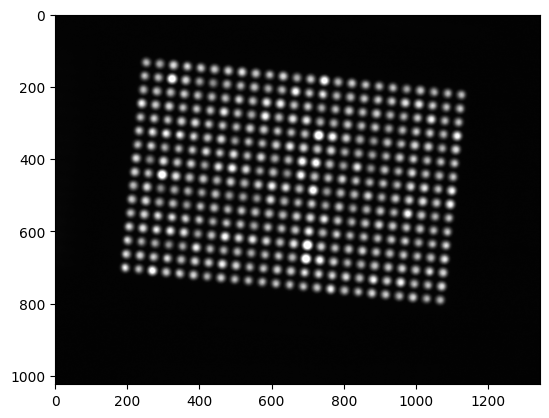

In [12]:
from pathlib import Path
from matplotlib import pyplot as plt

DATA_DIR = "/Users/antoinegerardin/Documents/data/rt-cetsa"
IMAGE_PATH = Path(
    f"{DATA_DIR}/20210318 LDHA compound plates/20210318 LDHA compound plate 1 6K cells/1.tif"
)

image = plt.imread(IMAGE_PATH)
plt.imshow(image, cmap='gray')
print(image.shape)
plt.show()

/Users/antoinegerardin/Documents/data/rt-cetsa/20210318 LDHA compound plates/20210318 LDHA compound plate 1 6K cells/1.tif
1
mean before rotate: 33217.45787920271
mean after rotate: 33234.52773425356


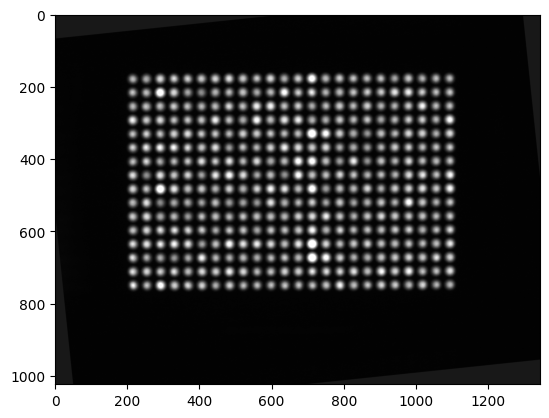

In [15]:
from skimage.transform import rotate
from bfio import BioWriter

TMP_DIR = Path("tmp")
print(IMAGE_PATH)
print(IMAGE_PATH.stem)
filepath = TMP_DIR / (IMAGE_PATH.stem + ".ome.tif")

mean = image.mean()

params = get_plate_params(image)
image_rotated : np.ndarray = rotate(
    image, params.rotate, preserve_range=True, mode="constant", cval=mean)
image_rotated.astype(image.dtype)
# image_rotated : np.ndarray = rotate(image, params.rotate, preserve_range=True)


plt.imshow(
    image_rotated,
    cmap="gray",
    vmin=image_rotated.min(),
    vmax=image_rotated.max()
)

with BioWriter(filepath) as bw:
    bw.Y, bw.X = image_rotated.shape
    bw[:] = image_rotated



In [ ]:
# NOTE Get the coordinate for each well
# TODO not clear
# Get X and Y indices
points = []
for p, mval in zip([cy, cx], [int(cy_min), int(cx_min)]):
    z_pos = list(p)
    z_pos.sort()
    z_index = 0
    z_count = 1
    Z = [z_pos[0]]
    for z in z_pos[1:]:
        if abs(Z[z_index] - z) < radii_mean // 3:
            Z[z_index] = (Z[z_index] * z_count + z) / (z_count + 1)
            z_count += 1
        else:
            Z[z_index] = int(Z[z_index])
            Z.append(z)
            z_index += 1
            z_count = 1
    Z[-1] = int(Z[-1])
    points.append(Z)

Y = points[0]
X = points[1]